# Starbucks Capstone Challenge
## Introduction
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.


## Example
To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Cleaning
This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Final Advice
Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## Problem Statement
The issue that I decided to tackle was to build a model that predicts whether a client will react to an offer. My procedure for taking care of this issue has two stages. To start with, I will join the offer portfolio, custoemr profile, and transaction information. Each row of this merged dataset will show an offer's attributes, customer demographic data and whether the offer was true. Second, I will assess the precision and F1-score of a guileless model that accepts all offers were fruitful. This gives me a benchmark for assessing the exhibition of models that I develop. Exactness quantifies how well a model accurately predicts whether an offer is fruitful. Nonetheless, if the level of effective or ineffective offers is low, precision is certifiably not a decent proportion of model execution. For this circumstance, assessing a models' exactness and review gives better understanding into its presentation. I picked the F1-score metric since it is "a weighted normal of the exactness and review measurements"


In [88]:
import re
import math
import json
!pip install progressbar
import progressbar
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
#conda install -c anaconda pandas 

In [2]:
# read in the json files - portfolio
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# read in the json files - profile
profile = pd.read_json('profile.json', orient='records', lines=True)
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
# read in the json files - transcript
transcript = pd.read_json('transcript.json', orient='records', lines=True)
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [6]:
portfolio.describe().T

,count,mean,std,min,25%,50%,75%,max
difficulty,10.0,7.7,5.831905,0.0,5.0,8.5,10.0,20.0
duration,10.0,6.5,2.321398,3.0,5.0,7.0,7.0,10.0
reward,10.0,4.2,3.583915,0.0,2.0,4.0,5.0,10.0


In [7]:
transcript.describe().T

,count,mean,std,min,25%,50%,75%,max
time,306534.0,366.38294,200.326314,0.0,186.0,408.0,528.0,714.0


## 1a- Cleaning portfolio data

In [8]:
# portfolio: rename id col name to offer_id.
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [9]:

# portfolio: one-hot encode offer_type column

for index, row in portfolio.iterrows():
    for offertype in ['bogo', 'informational', 'discount']:
        if offertype in portfolio.loc[index, 'offer_type']:
            portfolio.loc[index, offertype] = 1
        else:
            portfolio.loc[index, offertype] = 0
portfolio.drop(columns='offer_type', inplace=True)

In [10]:
# portfolio: one-hot encode channels

for index, row in portfolio.iterrows():
    for channel in ['web', 'email', 'social', 'mobile']:
        if channel in portfolio.loc[index, 'channels']:
            portfolio.loc[index, channel] = 1
        else:
            portfolio.loc[index, channel] = 0
portfolio.drop(columns='channels', inplace=True)

In [11]:
portfolio.head()

,difficulty,duration,offer_id,reward,bogo,informational,discount,web,email,social,mobile
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1.0,0.0,0.0,0.0,1.0,1.0,1.0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [12]:
portfolio.duplicated().sum()

0

## 1b- Cleaning profile data

In [13]:
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,17000.0,6.253141e+01,26.738580,18.0,45.0,58.0,73.0,118.0
became_member_on,17000.0,2.016703e+07,11677.499961,20130729.0,20160526.0,20170802.0,20171230.0,20180726.0
income,14825.0,6.540499e+04,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0


In [14]:
profile.head()


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
profile.shape

(17000, 5)

In [16]:
profile.age.unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

In [17]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)
profile.where(profile.age==118).count()

age                 2175
became_member_on    2175
gender                 0
customer_id         2175
income                 0
dtype: int64

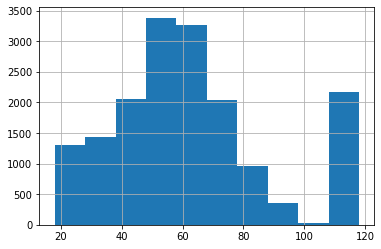

In [18]:
profile.age.hist()

In [19]:
# replace age value 118 with nan.
profile.age.replace(118, np.nan, inplace=True)

In [20]:
# change dateformat for became_member_on 
profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]')

In [23]:
profile.became_member_on.describe()

count                   17000
unique                   1716
top       2017-12-07 00:00:00
freq                       43
first     2013-07-29 00:00:00
last      2018-07-26 00:00:00
Name: became_member_on, dtype: object

In [24]:
len(profile[profile['gender'].isnull()].index)

2175

In [25]:
# dropping rows with no gender
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [26]:
# transform gender values to numeric 0s and 1s
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0)

In [ ]:
profile.gender.hist()

In [28]:
# add start_year column
profile['start_year'] = profile.became_member_on.dt.year
profile["start_month"] = profile.became_member_on.dt.month
profile.head()

,age,became_member_on,gender,customer_id,income,start_year,start_month
1,55.0,2017-07-15,0,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,75.0,2017-05-09,0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,68.0,2018-04-26,1,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,65.0,2018-02-09,1,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,58.0,2017-11-11,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11


## 1c- Cleaning transcript data

In [29]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [30]:
#check number of unique people represented
transcript['person'].nunique()

17000

In [31]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [32]:
#creating an id instead of person column
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [33]:
# creating distinct columns for amount and offer_id from value .

def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)

# change amount column type to float
transcript.amount.astype('float')

# drop value column
transcript.drop(columns=['value'], inplace=True)

In [34]:
# drop transaction rows where customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]
transcript.head()

,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [ ]:
transcript['time'] /= 24.0


In [36]:
# sum of duplicate values
transcript.duplicated().sum()

374

In [ ]:
# dropping the duplicated values, resetting the index
transcript.drop_duplicates(inplace=True)
transcript.reset_index(drop=True, inplace=True)

In [38]:
transcript.event.unique()


array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [39]:
# extracting transactions from transcript data
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)
transaction_df

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
11032,54890f68699049c2a04d415abc25e717,0.00,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
11047,629fc02d56414d91bca360decdfa9288,0.00,33.90
11051,a97e6f33219c432db82acfa0d19c602d,0.00,18.59
11055,676506bad68e4161b9bbaffeb039626b,0.00,18.01
11059,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0.00,19.11
11069,4cbe33c601a5407f8202086565c55111,0.00,36.19


In [40]:
transaction_df.describe()

,time,amount
count,123957.000000,123957.000000
mean,15.886592,13.996325
std,8.409545,31.749420
min,0.000000,0.050000
25%,8.750000,3.660000
50%,16.750000,10.800000
75%,23.000000,19.130000
max,29.750000,1062.280000


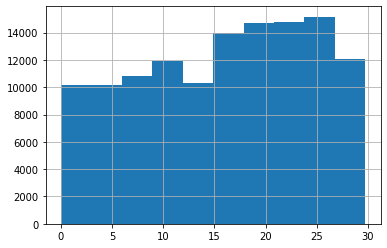

In [41]:
transaction_df.time.hist()

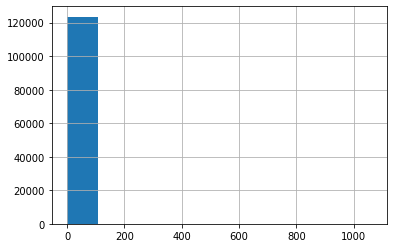

In [42]:
transaction_df.amount.hist()

In [43]:
# extracting offer-related from transcript data
offers_df = transcript[transcript.event!='transaction'].copy()

# one-hot encoding offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [44]:
offers_df.head()

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


In [45]:
transcript.event.value_counts()


transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [46]:
offers_df.received.sum()


66501

In [47]:
offers_df.viewed.sum()



49860

In [48]:
offers_df.completed.sum()

32070

In [49]:
offers_df

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.00,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
5,31dda685af34476cad5bc968bdb01c53,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
6,4b0da7e80e5945209a1fdddfe813dbe0,0.00,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0
7,c27e0d6ab72c455a8bb66d980963de60,0.00,3f207df678b143eea3cee63160fa8bed,1,0,0
8,d53717f5400c4e84affdaeda9dd926b3,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
9,f806632c011441378d4646567f357a21,0.00,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


## Data Exploration and Visualization:

In [50]:
profile.describe().T

,count,mean,std,min,25%,50%,75%,max
age,14825.0,54.393524,17.383705,18.0,42.0,55.0,66.0,101.0
gender,14825.0,0.572277,0.494765,0.0,0.0,1.0,1.0,1.0
income,14825.0,65404.991568,21598.299410,30000.0,49000.0,64000.0,80000.0,120000.0
start_year,14825.0,2016.620169,1.198245,2013.0,2016.0,2017.0,2017.0,2018.0
start_month,14825.0,6.695582,3.488853,1.0,4.0,7.0,10.0,12.0


In [51]:
profile.isnull().sum()


age                 0
became_member_on    0
gender              0
customer_id         0
income              0
start_year          0
start_month         0
dtype: int64

In [52]:
#gender distribution
profile.gender.value_counts()


1    8484
0    6341
Name: gender, dtype: int64

In [53]:
#percentage of customers who enrolled as a member by year
year_count = profile['start_year'].value_counts()

year_count *= 100 / year_count.sum()
#year_count

In [54]:

def hist_plot(data, title, xlabel, ylabel):
    plt.hist(data)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

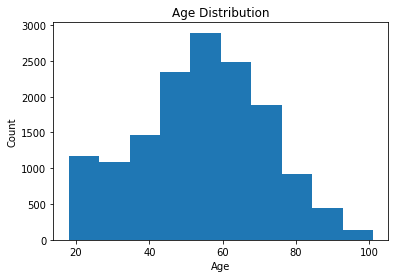

In [55]:
hist_plot(data=profile['age'], title='Age Distribution', xlabel='Age', ylabel='Count')


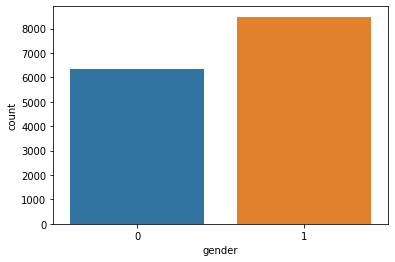

In [56]:
sns.countplot(profile['gender'])


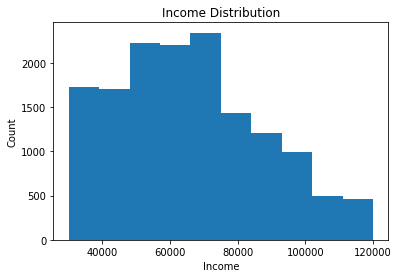

In [57]:
hist_plot(data=profile['income'], title='Income Distribution', xlabel='Income', ylabel='Count')


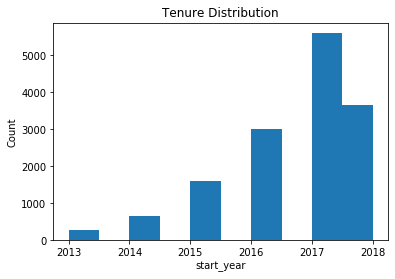

In [58]:
hist_plot(data=profile['start_year'], title='Tenure Distribution', xlabel='start_year', ylabel='Count')


In [59]:
#gender vs age

profile[['gender','age']].groupby(['gender'], as_index = False).mean().sort_values(by='age',ascending=False)


,gender,age
0,0,57.439836
1,1,52.116690


In [60]:
#gender vs income

profile[['gender','income']].groupby(['gender'], as_index = False).mean().sort_values(by='income',ascending=False)


,gender,income
0,0,71038.322031
1,1,61194.601603


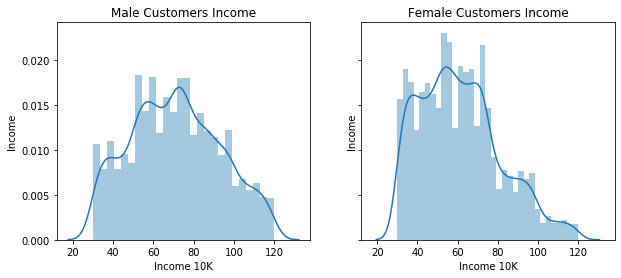

In [61]:
#Income distribution as a function a gender

#  male and female customers
male_custs = profile[profile['gender'] == 0]
female_custs = profile[profile['gender'] == 1]

# to be able to draw two subplots in a row
fig, ax = plt.subplots(figsize=(10, 4), nrows=1, ncols=2, sharex=True, sharey=True)

# plot a male customers income distribution
plt.sca(ax[0])
sns.distplot(male_custs['income'] * 1E-3)
plt.xlabel('Income 10K')
plt.ylabel('Income')
plt.title('Male Customers Income')

# plot a female customers income distribution
plt.sca(ax[1])
sns.distplot(female_custs['income'] * 1E-3)
plt.xlabel('Income 10K')
plt.ylabel('Income')
plt.title('Female Customers Income');

## 2a-Descriptive analysis / Transaction

In [62]:
transcript.head()


,event,customer_id,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
2,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,NaN
4,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [63]:
transcript.describe().T

,count,mean,std,min,25%,50%,75%,max
time,272388.0,15.270790,8.349273,0.00,7.75,17.0,22.00,29.75
amount,123957.0,13.996325,31.749420,0.05,3.66,10.8,19.13,1062.28


In [64]:
transcript['event'].value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

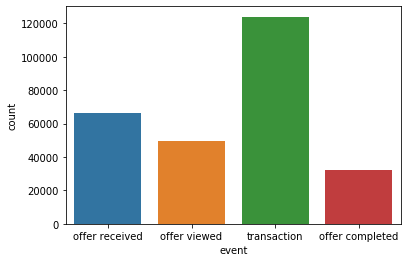

In [65]:
sns.countplot(transcript['event'])

In [66]:
#Merging offer, customer and transactions data
# https://progressbar-2.readthedocs.io/en/latest/#introduction

def combine_data(profile, portfolio, offers_df, transaction_df):
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    widgets=[
        ' [', progressbar.Timer(), '] ',
        progressbar.Bar(),
        ' (', progressbar.ETA(), ') ',
    ]
    
    # loop through all customer ids in offers_df
    for ind in progressbar.progressbar(range(len(customer_ids)), widgets=widgets):
        
        # get customer id from the list
        cust_id = customer_ids[ind]
        
        # extract customer profile from profile data
        customer = profile[profile['customer_id']==cust_id]
        
        # extract offers associated with the customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id']==cust_id]
        
        # extract transactions associated with the customer from transactions_df
        cust_transaction_data = transaction_df[transaction_df['customer_id']==cust_id]
        
        # extract received, completed, viewed offer data from customer offers
        offer_received_data = cust_offer_data[cust_offer_data['received'] == 1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] == 1]
        
        rows = []
        # loop through each received offer
        for i in range(offer_received_data.shape[0]):
            
            # fetch an offer id 
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from portfolio
            offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration_days = offer_row['duration'].values[0]
            
            # initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration_days
        
            # seggregate offers completed within end date
            off_completed_withintime = np.logical_and(
                offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
            
            # seggregate offers viewed within end date
            off_viewed_withintime = np.logical_and(
                offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)

            # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
            offer_successful = off_completed_withintime.sum() > 0 and off_viewed_withintime.sum() > 0
            
            # extract transactions occured within time
            transaction_withintime = np.logical_and(
                cust_transaction_data['time'] >= start_time, cust_transaction_data['time'] <= end_time)
        
            transaction_data = cust_transaction_data[transaction_withintime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
            }
                
            row.update(offer_row.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data


In [67]:
data = combine_data(profile, portfolio, offers_df, transaction_df)

 [Elapsed Time: 0:16:21] |##################################| (Time:  0:16:21) 


In [112]:
data.head()

,offer_id,total_amount,age,became_member_on,bogo,customer_id,difficulty,discount,duration,email,...,income,informational,mobile,offer_successful,reward,social,start_month,start_year,time,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,7,1.0,...,100000.0,0.0,1.0,1,5,0.0,5,2017,0.0,1.0
1,5a8bc65990b245e5a138643cd4eb9837,49.39,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,3,1.0,...,100000.0,1.0,1.0,0,0,1.0,5,2017,7.0,0.0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,10,0.0,7,1.0,...,100000.0,0.0,1.0,1,10,1.0,5,2017,17.0,0.0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,5,1.0,...,100000.0,0.0,1.0,1,5,1.0,5,2017,21.0,1.0
4,2906b810c7d4411798c6938adc9daaa5,0.00,68.0,2018-04-26,0.0,e2127556f4f64592b11af22de27a7932,10,1.0,7,1.0,...,70000.0,0.0,1.0,0,2,0.0,4,2018,0.0,1.0


In [70]:
data.head()

,age,became_member_on,bogo,customer_id,difficulty,discount,duration,email,gender,income,...,mobile,offer_id,offer_successful,reward,social,start_month,start_year,time,total_amount,web
0,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,7,1.0,0,100000.0,...,1.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,5,0.0,5,2017,0.0,37.67,1.0
1,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,3,1.0,0,100000.0,...,1.0,5a8bc65990b245e5a138643cd4eb9837,0,0,1.0,5,2017,7.0,49.39,0.0
2,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,10,0.0,7,1.0,0,100000.0,...,1.0,ae264e3637204a6fb9bb56bc8210ddfd,1,10,1.0,5,2017,17.0,48.28,0.0
3,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,5,1.0,0,100000.0,...,1.0,f19421c1d4aa40978ebb69ca19b0e20d,1,5,1.0,5,2017,21.0,48.28,1.0
4,68.0,2018-04-26,0.0,e2127556f4f64592b11af22de27a7932,10,1.0,7,1.0,1,70000.0,...,1.0,2906b810c7d4411798c6938adc9daaa5,0,2,0.0,4,2018,0.0,0.00,1.0


In [72]:
data.shape

(66501, 21)

In [73]:
data.columns.tolist()


['age',
 'became_member_on',
 'bogo',
 'customer_id',
 'difficulty',
 'discount',
 'duration',
 'email',
 'gender',
 'income',
 'informational',
 'mobile',
 'offer_id',
 'offer_successful',
 'reward',
 'social',
 'start_month',
 'start_year',
 'time',
 'total_amount',
 'web']

In [77]:
column_order = ['offer_id', 'total_amount']
column_order.extend([elem for elem in data.columns if elem not in column_order])

data = data[column_order]
data

,offer_id,total_amount,age,became_member_on,bogo,customer_id,difficulty,discount,duration,email,...,income,informational,mobile,offer_successful,reward,social,start_month,start_year,time,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,7,1.0,...,100000.0,0.0,1.0,1,5,0.0,5,2017,0.0,1.0
1,5a8bc65990b245e5a138643cd4eb9837,49.39,75.0,2017-05-09,0.0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,3,1.0,...,100000.0,1.0,1.0,0,0,1.0,5,2017,7.0,0.0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,10,0.0,7,1.0,...,100000.0,0.0,1.0,1,10,1.0,5,2017,17.0,0.0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,75.0,2017-05-09,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,5,1.0,...,100000.0,0.0,1.0,1,5,1.0,5,2017,21.0,1.0
4,2906b810c7d4411798c6938adc9daaa5,0.00,68.0,2018-04-26,0.0,e2127556f4f64592b11af22de27a7932,10,1.0,7,1.0,...,70000.0,0.0,1.0,0,2,0.0,4,2018,0.0,1.0
5,3f207df678b143eea3cee63160fa8bed,0.00,68.0,2018-04-26,0.0,e2127556f4f64592b11af22de27a7932,0,0.0,4,1.0,...,70000.0,1.0,1.0,0,0,0.0,4,2018,14.0,1.0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,18.42,68.0,2018-04-26,1.0,e2127556f4f64592b11af22de27a7932,5,0.0,7,1.0,...,70000.0,0.0,1.0,1,5,0.0,4,2018,17.0,1.0
7,fafdcd668e3743c1bb461111dcafc2a4,18.42,68.0,2018-04-26,0.0,e2127556f4f64592b11af22de27a7932,10,1.0,10,1.0,...,70000.0,0.0,1.0,1,2,1.0,4,2018,21.0,1.0
8,f19421c1d4aa40978ebb69ca19b0e20d,9.54,65.0,2018-02-09,1.0,389bc3fa690240e798340f5a15918d5c,5,0.0,5,1.0,...,53000.0,0.0,1.0,1,5,1.0,2,2018,0.0,1.0
9,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,65.0,2018-02-09,1.0,389bc3fa690240e798340f5a15918d5c,5,0.0,7,1.0,...,53000.0,0.0,1.0,0,5,0.0,2,2018,7.0,1.0


In [81]:
data_new = data.drop(columns=['time', 'email', 'informational', 'became_member_on'])
data_new.head()

,offer_id,total_amount,age,bogo,customer_id,difficulty,discount,duration,gender,income,mobile,offer_successful,reward,social,start_month,start_year,web
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,75.0,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,7,0,100000.0,1.0,1,5,0.0,5,2017,1.0
1,5a8bc65990b245e5a138643cd4eb9837,49.39,75.0,0.0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,3,0,100000.0,1.0,0,0,1.0,5,2017,0.0
2,ae264e3637204a6fb9bb56bc8210ddfd,48.28,75.0,1.0,78afa995795e4d85b5d9ceeca43f5fef,10,0.0,7,0,100000.0,1.0,1,10,1.0,5,2017,0.0
3,f19421c1d4aa40978ebb69ca19b0e20d,48.28,75.0,1.0,78afa995795e4d85b5d9ceeca43f5fef,5,0.0,5,0,100000.0,1.0,1,5,1.0,5,2017,1.0
4,2906b810c7d4411798c6938adc9daaa5,0.00,68.0,0.0,e2127556f4f64592b11af22de27a7932,10,1.0,7,1,70000.0,1.0,0,2,0.0,4,2018,1.0


## Modeling

In [83]:
from sklearn.model_selection import train_test_split

X = data_new.drop(['offer_successful','customer_id', 'offer_id'], axis=1)
y = data_new['offer_successful']

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 53200 samples.
Testing set has 13301 samples.


In [87]:
target_variable_names=['Offer failed', 'Offer successful']

from sklearn.metrics import accuracy_score, f1_score

lg_reg = LogisticRegression(random_state=42)
lg_reg.fit(X_train, y_train)
lg_pred = lg_reg.predict(X_test)

print('LogisticRegression Model')
print(classification_report(y_test, lg_pred, target_names=target_variable_names))

C:\Users\TCCAKTURK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression Model
                  precision    recall  f1-score   support

    Offer failed       0.85      0.91      0.88      6998
Offer successful       0.89      0.83      0.86      6303

        accuracy                           0.87     13301
       macro avg       0.87      0.87      0.87     13301
    weighted avg       0.87      0.87      0.87     13301



In [90]:


neighbors = KNeighborsClassifier()
neighbors.fit(X_train, y_train)
neighbors_pred = neighbors.predict(X_test)

print('KNeighborsClassifier Model')
print(classification_report(y_test, neighbors_pred, target_names=target_variable_names))

KNeighborsClassifier Model
                  precision    recall  f1-score   support

    Offer failed       0.91      0.85      0.88      6998
Offer successful       0.84      0.91      0.87      6303

        accuracy                           0.88     13301
       macro avg       0.88      0.88      0.88     13301
    weighted avg       0.88      0.88      0.88     13301



In [91]:

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print('RandomForestClassifier Model')
print(classification_report(y_test, rf_pred, target_names=target_variable_names))

RandomForestClassifier Model
                  precision    recall  f1-score   support

    Offer failed       0.93      0.90      0.91      6998
Offer successful       0.89      0.92      0.91      6303

        accuracy                           0.91     13301
       macro avg       0.91      0.91      0.91     13301
    weighted avg       0.91      0.91      0.91     13301



## Evaluation of Model Output

Logistic regression:
Precision: 0.87
Recall: 0.87
F1 score: 0.87

KNeighbors classifier
Precision: 0.88
Recall: 0.88
F1 score: 0.88

Random forest classifier:
Precision: 0.91
Recall: 0.91
F1 score: 0.91

Random forest classifier is the best model in terms of overall score 

## Model tuning

In [93]:
# Get model parameters
print(rf_clf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [95]:
n_estimators = [100, 200]
max_features = ['auto', 'sqrt']
max_depth = [10, 50, 100]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_2 = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.9min finished


{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [99]:
rf_2 = RandomForestClassifier(n_estimators= 200,
 min_samples_split= 10,
 min_samples_leaf= 1,
 max_features = 'auto',
 max_depth = 10,
 bootstrap = True)

rf_2.fit(X_train, y_train)
rf_pred = rf_2.predict(X_test)

print('RandomForestClassifier Model')
print(classification_report(y_test, rf_pred, target_names=target_variable_names))

RandomForestClassifier Model
                  precision    recall  f1-score   support

    Offer failed       0.94      0.89      0.92      6998
Offer successful       0.88      0.94      0.91      6303

        accuracy                           0.91     13301
       macro avg       0.91      0.91      0.91     13301
    weighted avg       0.91      0.91      0.91     13301



##  Feature Significance

In [106]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#a00000', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

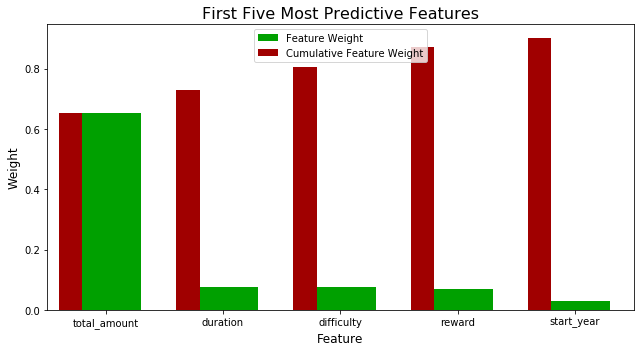

In [108]:
significance = rf.feature_importances_

feature_plot(significance, X_train, y_train)


Five most features for offer success prediction are:

total_amount: The amount of money spent on a purchase.

duration: Duration of offer.

difficulty: Offer difficulty

reward: The amount of reward for the offer.

start_year: The year of becoming a member

In [111]:
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(significance)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(significance)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
from sklearn.base import clone
clf = (clone(rf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, rf_pred)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, rf_pred)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, reduced_predictions)))

Final Model trained on full data
------
Accuracy on testing data: 0.9133
F-score on testing data: 0.9113

Final Model trained on reduced data
------
Accuracy on testing data: 0.9105
F-score on testing data: 0.9086
